In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [102]:
import itertools
import pickle
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import DeterministicProcess

from src.features import build_features
from src.models import train_model

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
DIAGS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J955",
    "M348",
    "T820",
    "T821",
    "Z450",
]

In [4]:
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# 1. Proyección de Egresos Hospitalarios para Diagnósticos más frecuentes en el INT

En este cuadernillo se quiere crear un modelo para estimar la proyección de egresos
hospitalarios para los diagnósticos más relevantes para el INT hasta el año 2035. Para realizar
la proyección se utilizará el modelo Prophet, y se hará una proyección por día.

Para este análisis se obviará el año 2019 para entrenar/testear el modelo. Esto, ya que es un
año anómalo.

In [5]:
df = egresos_torax.query("ANO_EGRESO <= 2019")
df = df[df["DIAG1"].isin(DIAGS_RELEVANTES)]
df = df.drop(
    columns={
        "ANO_EGRESO",
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    }
)


# Agrupa por día y genera un calendario completo hasta el 2019 (imputa días faltantes)
df = df.groupby("FECHA_EGRESO").sum().resample("D").sum()
df = df.drop(columns="DIAG1")

## 1.1 Separación de muestra y Modelamiento

In [6]:
CORTE_VALID = "2019-01-01"

train = df[df.index < CORTE_VALID]
valid = df[df.index >= CORTE_VALID]

## 1.2 Preprocesamiento para Modelo Prophet

El modelo prophet requiere 2 columnas para hacer la proyección

In [17]:
train_prophet = (
    train.copy()
    .reset_index()[["FECHA_EGRESO", "n_egresos"]]
    .rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})
)

valid_prophet = (
    valid.copy()
    .reset_index()[["FECHA_EGRESO", "n_egresos"]]
    .rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})
)

In [18]:
param_grid = {
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.01, 0.1, 1.0, 10.0],
    "holidays_prior_scale": [0.01, 0.1, 1.0, 10.0],
    # "seasonality_mode": ["additive", "multiplicative"],
}

In [19]:
# Genera todas las combinaciones de hiperparametros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
rmses_val = []

In [20]:
CUTOFFS = pd.to_datetime(["2014-01-01", "2015-01-01", "2016-01-01", "2017-01-01"])

# Entrena con validacion cruzada
for params in all_params:
    modelo = Prophet(**params).add_country_holidays("Chile").fit(train_prophet)
    df_cv = cross_validation(modelo, cutoffs=CUTOFFS, horizon="365 days", parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    
    yhat_val = modelo.predict(valid_prophet.drop(columns="y"))["yhat"]
    rmse_val = np.sqrt(mean_squared_error(valid_prophet["y"], yhat_val))
    rmses_val.append(rmse_val)
    
# Encuentra los mejores parametros
tuning_results = pd.DataFrame(all_params)
tuning_results["rmse"] = rmses
tuning_results["rmse_val"] = rmses_val

09:08:09 - cmdstanpy - INFO - Chain [1] start processing
09:08:09 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
09:08:10 - cmdstanpy - INFO - Chain [1] start processing
09:08:10 - cmdstanpy - INFO - Chain [1] done processing
09:08:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:08:10 - cmdstanpy - INFO - Chain [1] start processing
09:08:10 - cmdstanpy - INFO - Chain [1] start processing
09:08:10 - cmdstanpy - INFO - Chain [1] start processing
09:08:10 - cmdstanpy - INFO - Chain [1] done processing
09:08:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:

In [21]:
best_params = all_params[np.argmin(rmses_val)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0}


In [22]:
modelo_optimo = Prophet(**best_params).add_country_holidays("Chile").fit(train_prophet)

09:09:48 - cmdstanpy - INFO - Chain [1] start processing
09:09:48 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
yhat = modelo_optimo.predict(valid_prophet.drop(columns="y"))
rmse = np.sqrt(mean_squared_error(valid_prophet["y"], yhat["yhat"]))
print(f"El RMSE con el conjunto de validación fue de: {rmse:.2f}")

El RMSE con el conjunto de validación fue de: 2.52


# 2. Predicción de Egresos hasta 2035

In [24]:
futuro = modelo_optimo.make_future_dataframe(periods=(366*16), include_history=False)
forecasting = modelo_optimo.predict(futuro)

<Axes: xlabel='ds'>

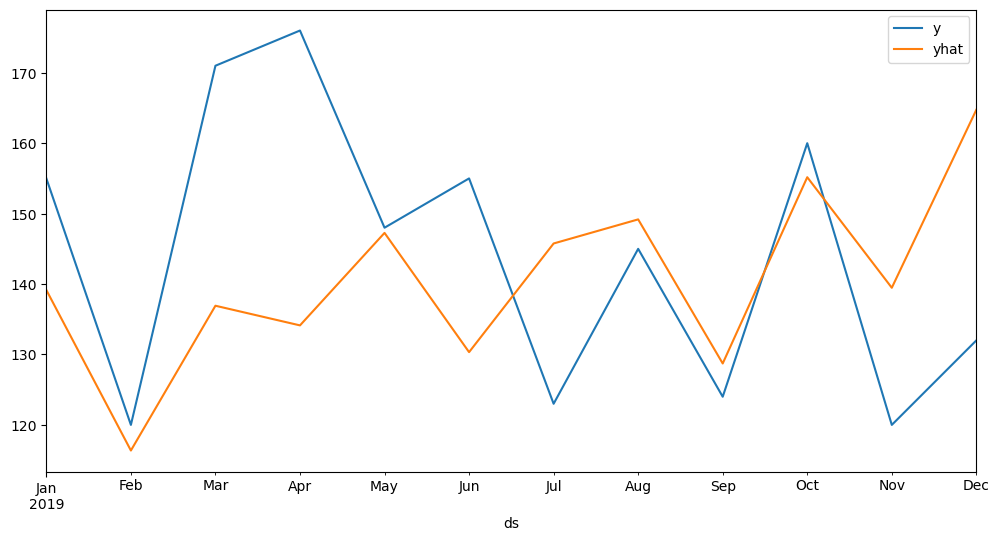

In [25]:
fig, axis = plt.subplots()
valid_prophet.set_index("ds").resample("M").sum().plot(ax=axis)
forecasting.query("ds < '2020-01-01'").set_index("ds").resample("M").sum().plot(y="yhat", ax=axis)

A pesar de haber optimizado el entrenamiento del modelo Prophet, se observa claramente que presenta
diferencias significativas con el conjunto de validación. Por lo tanto, es necesario entrenar un
modelo más fidedigno.

# 3. Modelo Híbrido

## 3.1 Preprocesamiento Modelo Híbrido

In [121]:
TARGET = "n_egresos"

# Train Set (To use for cross-validation and hyperparameter tuning)
train_hibrido = train[[TARGET]]

X_train_1 = DeterministicProcess(index=train_hibrido.index, order=1, drop=True).in_sample()
X_train_2 = build_features.create_features_datetime_index(train_hibrido).drop(columns=TARGET)
# X_train_2 = build_features.create_lag_features(X_train_2, TARGET, [1, 7, 14, 30, 365], 0).drop(
#     columns=TARGET
# )

y_train = train_hibrido[TARGET]

# Validation Set
valid_hibrido = valid[[TARGET]]
ULTIMO_TREND_TRAIN = X_train_1.iloc[-1, 0]

X_valid_1 = (
    DeterministicProcess(index=valid_hibrido.index, order=1, drop=True).in_sample()
    + ULTIMO_TREND_TRAIN
)
X_valid_2 = build_features.create_features_datetime_index(valid_hibrido).drop(columns=TARGET)
# X_valid_2 = build_features.create_lag_features(X_valid_2, TARGET, [1, 7, 14, 30, 365], 0).drop(
#     columns=TARGET
# )
y_valid = valid_hibrido[TARGET]

## 3.2 Entrenamiento del Modelo Hibrido

In [122]:
# Define models

modelo_1 = LinearRegression()
modelo_2 = XGBRegressor()


# Create the hyperparameter grids for each model
param_grid_1 = {"fit_intercept": [True, False]}

param_grid_2 = {
    "max_depth": range(2, 10, 1),
    "n_estimators": range(60, 220, 40),
    "learning_rate": [0.1, 0.01, 0.05],
}

# Example usage
# Assuming modelo_1 and modelo_2 are instances of scikit-learn models

# Create the hybrid model
hybrid_model = train_model.ModeloHibrido(
    modelo_1, modelo_2, param_grid_1, param_grid_2, n_splits=5
)

# Fit the model
hybrid_model.fit(X_train_1, X_train_2, y_train, X_valid_1, X_valid_2, y_valid)

Tuning modelo_1...
Best hyperparameters for modelo_1: {'fit_intercept': True}
CV Results for modelo_1:
  Mean Train Score: -1.9476417347095305
  Mean Test Score: -2.793193519226406

Tuning modelo_2...
Best hyperparameters for modelo_2: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
CV Results for modelo_2:
  Mean Train Score: -1.7235324325698274
  Mean Test Score: -5.11379814726343

Training process completed.
Performance on Validation Set:
  Root Mean Squared Error: 2.4562639731645235
  R-squared: 0.5034377140695812



In [123]:
valid_hibrido["yhat"] = hybrid_model.predict(X_valid_1, X_valid_2)

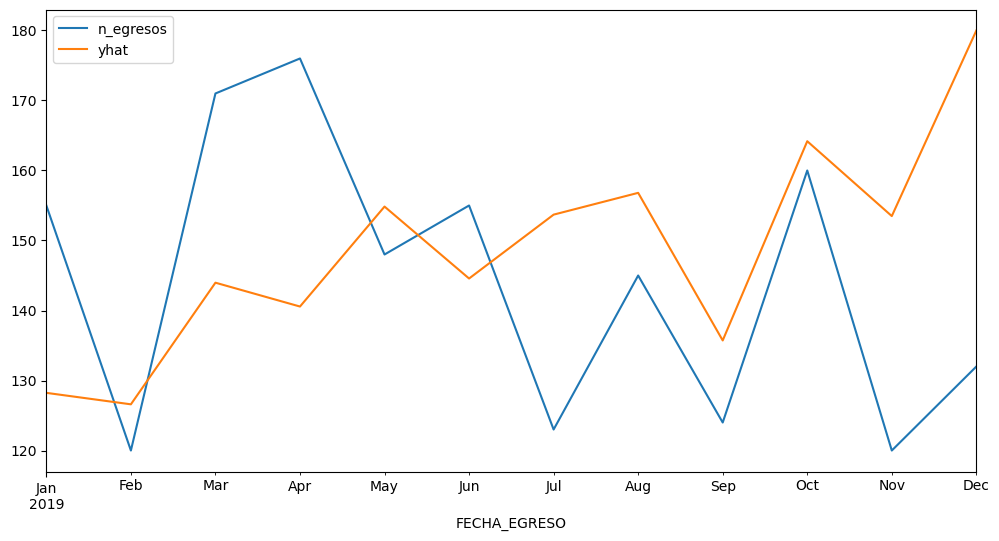

In [124]:
valid_hibrido.resample("M").sum().plot()
plt.show()

In [125]:
train_hibrido["yhat"] = hybrid_model.predict(X_train_1, X_train_2)

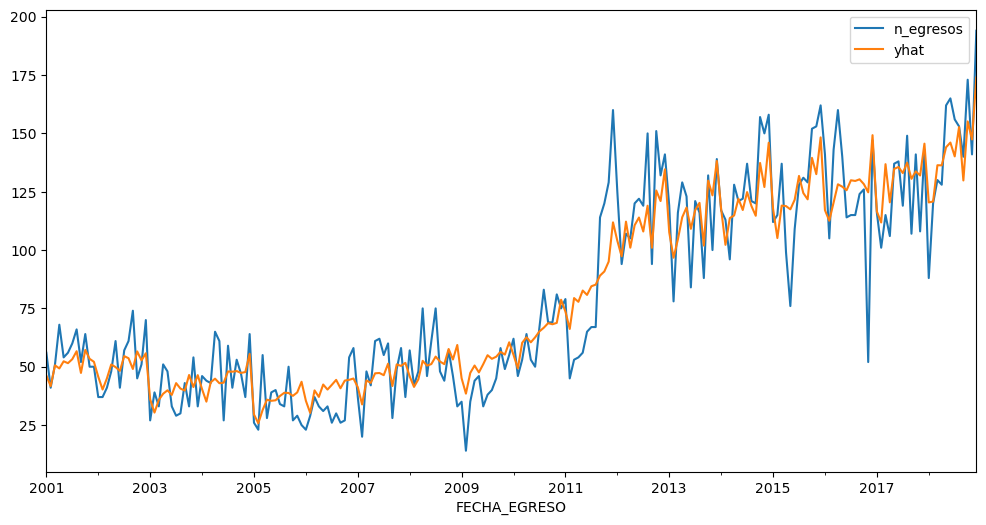

In [126]:
train_hibrido.resample("M").sum().plot()
plt.show()

In [127]:
with open("../models/hybrid_model.pickle", "wb") as file:
    pickle.dump(hybrid_model, file)

## Predicción del Futuro con modelo Hibrido

In [133]:
futuro = pd.DataFrame(index=pd.date_range("2020-01-01", "2035-12-31"))

In [134]:
ULTIMO_TREND_VALID = X_valid_1.iloc[-1, 0]

X_futuro_1 = (
    DeterministicProcess(index=futuro.index, order=1, drop=True).in_sample()
    + ULTIMO_TREND_VALID
)
X_futuro_2 = build_features.create_features_datetime_index(futuro)

In [135]:
futuro["prediccion"] = hybrid_model.predict(X_futuro_1, X_futuro_2)

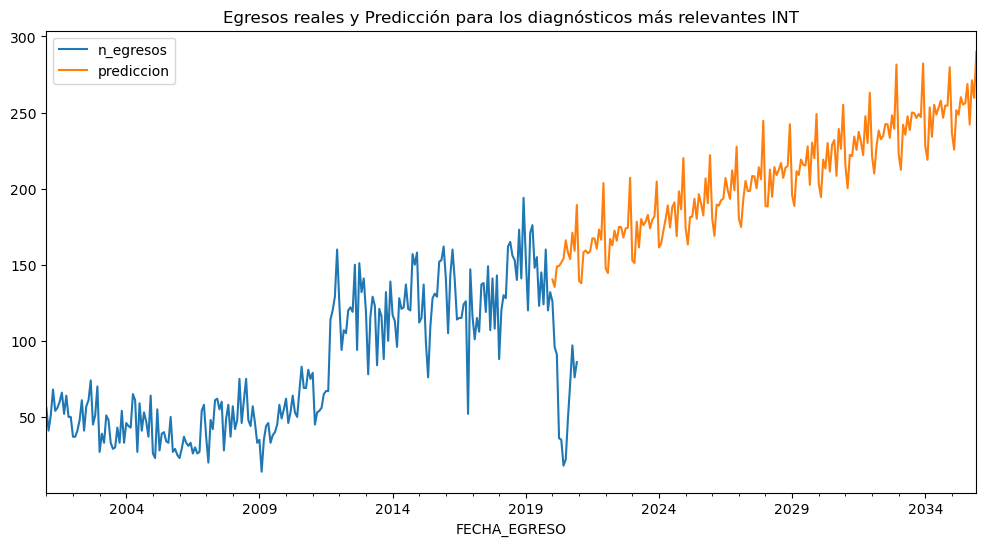

In [157]:
fig, axis = plt.subplots()

egresos_reales_diags_relevantes = (
    egresos_torax[egresos_torax["DIAG1"].isin(DIAGS_RELEVANTES)]
    .groupby("FECHA_EGRESO")
    .sum()
    .resample("M")[["n_egresos"]]
    .sum()
)

egresos_reales_diags_relevantes.plot(label="Egresos Reales", ax=axis)
futuro.resample("M").sum().plot(label="Predicción", ax=axis)
plt.legend()
plt.title("Egresos reales y Predicción para los diagnósticos más relevantes INT")
plt.show()

In [164]:
resumen_egresos_futuros = futuro.resample("Y").sum()
resumen_egresos_reales = egresos_reales_diags_relevantes.resample("Y").sum()